|        |        |        |
|--------|--------|--------|
![H-BRS](logos/h-brs.png) | ![A2S](logos/a2s.png) | ![b-it](logos/b-it.png) |

# Autonomous Mobile Robots

# AMR Assignment 1

### General information

* Please do not add or delete any cells. Answers belong into the already provided cells (below the question).
* If a function is given (either as a signature or a full function), you should not change the name, arguments, or return value of the function.
* If you encounter empty cells underneath the answer that can not be edited, please ignore them; they are for testing purposes.
* Please note that variables declared in the notebook cells have global scope. To make sure your assignment works correctly as a whole, please restart the kernel and run all cells before submitting (e.g. via *Kernel -> Restart & Run All*).
* Code cells where you are supposed to give your answer often include the line  ```raise NotImplementedError```. This makes it easier to automatically grade answers. Once you fill out a function, please delete this line.

### Submission

Please make sure to write all your team members 2s IDs in the cell below before submission. Please submit your notebook via the JupyterHub web interface (in the main view -> Assignments -> Submit). If it is a group assignment, please make only one submission per group (for easier bookkeeping, it is best if this is always the same team member).

### Questions about the assignment

If you have questions about the assignment, you are encouraged to post them in the LEA forum. Proactive discussions lead to better understanding. Let's keep the forum active.

## Team members (2s IDs):

* anuhel2s
* mkhan2s
* fmasum2s

# LiDAR Data Collection and Visualisation (in Simulation)

In this assignment, you will run the Robile in simulation and collect some sensor data, followed by the visualisation of the laser scanner sensor data.

Please refer to the [documentation](https://robile-amr.readthedocs.io/en/latest/source/getting_started.html) to set up the system before running the simulation. You will then plot the laser data separately with respect to two different frames. To plot the data, you will need to record the bag file and transform it to the desired reference frame.

## Recording the bag file

Once you have set up your ROS2 environment and corresponding repositories to run the Robile in simulation, please record the bag file to store the data on desired topics. Follow this [tutorial](https://robile-amr.readthedocs.io/en/latest/source/Tutorial/Demo%20Simulation.html) to run the Robile in simulation. In case you  receive notification that some packages are missing, please install the missing packages using `pip` and report this in the LEA forum, as this will help us update the documentation accordingly.

You can learn more about bag files, the procedure for recording and playing them in this [documentation](https://docs.ros.org/en/humble/Tutorials/Beginner-CLI-Tools/Recording-And-Playing-Back-Data/Recording-And-Playing-Back-Data.html). If not already installed, please install the `ros2bag` package using the following commands:

```
sudo apt-get install ros-humble-ros2bag 
sudo apt-get install ros-humble-rosbag2-storage-default-plugins
```

Once the Robile simulation is running, open a new terminal and source the ROS2 humble workspace. In a terminal, go to the directory where you would like to save the bag file and run the following command to save data on all topics:

```
ros2 bag record -o file_name -a
```

You can now move the robot around in the simulation. Press `Ctrl+C` to stop recording and save the bag file. Now you should be able to see a directory with the name `file_name`, which contains a `.db3` and a `.yaml` file. Note that, to save data on particular topics, `-a` can be replaced by all topic names separated by space. For example, in this assignment, the topics **/scan**, **/tf**, and **/tf_static** are relevant, so the coresponding command to save data on these topic would be
```
ros2 bag record -o file_name /scan /tf /tf_static
```

Before proceeding with the visualisation and transformation of the data, we will first setup the system by installing some necessary packages. Please install the required packages by executing these commands:
```
pip install rosbag2_py
pip install rosbags
pip install transforms3d
```

Now we will import all necessary packages for working with the ROS bag and the data contained in it.

In [42]:
import rclpy
from rosbag2_py import StorageOptions, ConverterOptions, SequentialReader
from rclpy.serialization import deserialize_message
from sensor_msgs.msg import LaserScan
from tf2_msgs.msg import TFMessage
import tf2_ros
import tf_transformations
from geometry_msgs.msg import Quaternion
from transforms3d.quaternions import quat2mat

import numpy as np
import matplotlib.pyplot as plt
import os

## Task 1: Reading LiDAR Data [15 Points]

In the below Rviz-based visualisation of the Robile, you can see two frames: `base_laser_front_link` and `base_link` (all other frames are hidden for readability). `base_laser_front_link` is the frame with respect to which the laser scan data are measured, and `base_link` is the frame attached to the robot, which acts as a reference frame with respect to which we represent most of the robot components and sensor readings.

![Frames.png](img/Frames.png)

In this task, collect the scan data closest to a user-defined timestamp value from the robot. For this, you need to extract data from the bag file. **Please do not upload the bag file with your submission.**

**Note:** Under [sensor messages](https://index.ros.org/p/sensor_msgs/), you can find different message definitions from ROS. [LaserScan](http://docs.ros.org/en/melodic/api/sensor_msgs/html/msg/LaserScan.html) is the data structure of a ROS message which is used to represent laser scan data. Similarly, transformation data between frames is represented using the [TFMessage](http://docs.ros.org/en/jade/api/tf2_msgs/html/msg/TFMessage.html) data structure.

**Reference**: The [documentation](https://ternaris.gitlab.io/rosbags/topics/rosbag2.html) on reading rosbag2 messages may be helpful in reading the desired data from the bag files.

In [43]:
import rclpy
from rosbag2_py import StorageOptions, ConverterOptions, SequentialReader
from rclpy.serialization import deserialize_message
from sensor_msgs.msg import LaserScan

# Function to read the bag file and get the closest LaserScan to a user-defined timestamp
def read_bagfile_and_get_closest_scan(bag_file_path, target_timestamp):
    storage_options = StorageOptions(uri=bag_file_path, storage_id='sqlite3')
    converter_options = ConverterOptions(input_serialization_format='cdr', output_serialization_format='cdr')
    reader = SequentialReader()
    reader.open(storage_options, converter_options)

    closest_scan = None
    closest_time_diff = float('inf')  # Start with a large time difference

    # Convert user-defined timestamp to ROS2 Time using nanoseconds
    target_time_ros2 = rclpy.time.Time(seconds=target_timestamp)
    
    while reader.has_next():
        topic, data, t = reader.read_next()

        if topic == '/scan':
            laser_msg = deserialize_message(data, LaserScan)
            
            # Convert the message's timestamp to ROS2 time
            scan_time_ros2 = rclpy.time.Time.from_msg(laser_msg.header.stamp)

            # Calculate the time difference between this scan and the target timestamp
            time_diff = abs(target_time_ros2.nanoseconds - scan_time_ros2.nanoseconds)  # Time difference in nanoseconds
            
            # If this scan is closer to the target timestamp, update the closest scan
            if time_diff < closest_time_diff:
                closest_scan = laser_msg
                closest_time_diff = time_diff

    # Print and return the closest scan if found
    if closest_scan:
        print(f"Closest scan found with timestamp {closest_scan.header.stamp} (time difference: {closest_time_diff} nanoseconds)")
        return closest_scan
    else:
        print("No scan data found.")
        return None

## Task 2: Cartesian Representation of Data  [30 points]

You have to convert the scan data from polar coordinates to cartesian coordinates for better interpretation and integration with other functionalities. For this, you need to get the minimum and maximum angular range of the laser scanner and also the resolution of angles (which gives you the number of data points in a single scan).

**Note:** You need to figure out how can you get these details from `scan_data`. Also, it might interest you to know with respect to which frame the data was published.

In [44]:
def convert_scan_to_cartesian(laser_scan):
    ranges = laser_scan.ranges
    angles = [laser_scan.angle_min + i * laser_scan.angle_increment for i in range(len(ranges))]
    
    # Convert to Cartesian coordinates
    cartesian_coords = []
    x_points = []
    y_points = []
    for i in range(len(ranges)):
        if ranges[i] != float('inf'):  # Only consider valid range values
            x = ranges[i] * np.cos(angles[i])
            y = ranges[i] * np.sin(angles[i])
            cartesian_coords.append((x, y))
            x_points.append(x)
            y_points.append(y)
    
    return x_points, y_points


## Task 3: Scan Visualisation [10 Points]

Plot the points using the Cartesian coordinates from your above implementation.  

**Note:** Please make sure that your plot has a corresponding title, axis labels, grid, and legend.

In [45]:
import matplotlib.pyplot as plt

# Function to plot polar coordinates from LaserScan data
def plot_polar(laser_scan):
    ranges = laser_scan.ranges
    angles = [laser_scan.angle_min + i * laser_scan.angle_increment for i in range(len(ranges))]

    
    filtered_ranges = [r for r in ranges if r != float('inf')]
    filtered_angles = [angles[i] for i in range(len(ranges)) if ranges[i] != float('inf')]

    plt.figure(figsize=(8, 8))
    ax = plt.subplot(111, projection='polar')

    ax.scatter(filtered_angles, filtered_ranges, s=1)
    ax.set_title('Laser Scan Data in Polar Coordinates')

    # Set radial ticks based on valid ranges
    if filtered_ranges:
        max_range = max(filtered_ranges)
        ax.set_rticks([i for i in range(0, int(max_range), int(max_range / 4))])

    plt.show()

    print("First 10 polar coordinates (angle, range):")
    for i in range(min(10, len(filtered_ranges))):
        print(f"Angle: {filtered_angles[i]:.2f} radians, Range: {filtered_ranges[i]:.2f} meters")


def plot_cartesian(x_points, y_points):
    plt.figure(figsize=(8, 8))
    plt.scatter(x_points, y_points, s=1)
    plt.title('Laser Scan Data in Cartesian Coordinates')
    plt.xlabel('X (meters)')
    plt.ylabel('Y (meters)')
    plt.grid(True)
    plt.show()

## Task 4:  Scan Transformation to base_link [35 Points]

Your next task is to transform the scan data with respect to `base_link` and then plot the resulting points. Part of this task is to figure out the topic under which this transformation details are being published, and then use that information to perform this transformation.

**Tip:** In order to get the Euler angle rotation (i.e. the (roll, pitch, yaw) angles) from the transformation matrix, the method `tf_transformations.euler_from_quaternion` can be used.

In [46]:
def extract_tf_static_transformations(bag_file_path):
  
    tf_static_coordinates = []

    reader = SequentialReader()
    storage_options = StorageOptions(uri=bag_file_path, storage_id='sqlite3')
    converter_options = ConverterOptions(input_serialization_format='cdr', output_serialization_format='cdr')
    
    reader.open(storage_options, converter_options)

    while reader.has_next():
        topic, data, timestamp = reader.read_next()

        if topic == '/tf_static':
            msg_static = deserialize_message(data, TFMessage)

            if msg_static.transforms:
                # Extract translation components
                x_msg = msg_static.transforms[0].transform.translation.x
                y_msg = msg_static.transforms[0].transform.translation.y
                z_msg = msg_static.transforms[0].transform.translation.z

                # Extract rotation (quaternion) components
                qx = msg_static.transforms[0].transform.rotation.x
                qy = msg_static.transforms[0].transform.rotation.y
                qz = msg_static.transforms[0].transform.rotation.z
                qw = msg_static.transforms[0].transform.rotation.w

                # Create translation vector and rotation matrix
                translation = np.array([x_msg, y_msg, z_msg])
                rotation_matrix = quat2mat([qw, qx, qy, qz])

                # Create a 4x4 transformation matrix
                transformation_matrix = np.eye(4)
                transformation_matrix[:3, :3] = rotation_matrix
                transformation_matrix[:3, 3] = translation

                # Append the transformation matrix to the list
                tf_static_coordinates.append(transformation_matrix)
            else:
                print("Warning: Empty 'transforms' field in message from topic '/tf_static'")

    return tf_static_coordinates

def transform_lidar_points(x_points, y_points, transformation_matrix):

    # Convert the LiDAR points to homogeneous coordinates
    lidar_points = np.vstack((x_points, y_points, np.zeros_like(x_points), np.ones_like(x_points)))

    # Apply the transformation
    transformed_points = transformation_matrix @ lidar_points

    # Extract the transformed X and Y coordinates
    x_transformed = transformed_points[0, :]
    y_transformed = transformed_points[1, :]

    return x_transformed, y_transformed

## Task 5:  Scan Visualisation in base_link [5 Points]

Plot the points using the Cartesian coordinates from your above implementation after transformation to `base_link`. 

**Note:** Please make sure that your plot has a corresponding title, axis labels, grid, and legend.

In [47]:
def plot_lidar_scan(x_points, y_points):
    
    plt.figure(figsize=(8, 8))
    plt.scatter(x_points, y_points, s=1, c='red', label="LiDAR Points (base_link)")
    plt.title('LiDAR Scan Visualization in base_link Frame')
    plt.xlabel('X (meters)')
    plt.ylabel('Y (meters)')
    plt.grid(True)
    plt.legend()
    plt.show()


[INFO] [1729770146.790288126] [rosbag2_storage]: Opened database '../../bag_22_10_24/bag_23_04_24_0.db3' for READ_ONLY.
[INFO] [1729770146.857072190] [rosbag2_storage]: Opened database '../../bag_22_10_24/bag_23_04_24_0.db3' for READ_ONLY.


Extracted 2 transformation matrices from /tf_static.
Closest scan found with timestamp builtin_interfaces.msg.Time(sec=83, nanosec=509000000) (time difference: 902492000000 nanoseconds)
LaserScan ranges (first 10 values): array('f', [3.4754691123962402, 3.4357364177703857, 3.3912811279296875, 3.3250598907470703, 3.2726082801818848, 3.255305290222168, 3.193357467651367, 3.1716692447662354, 3.145189046859741, 3.1029505729675293])


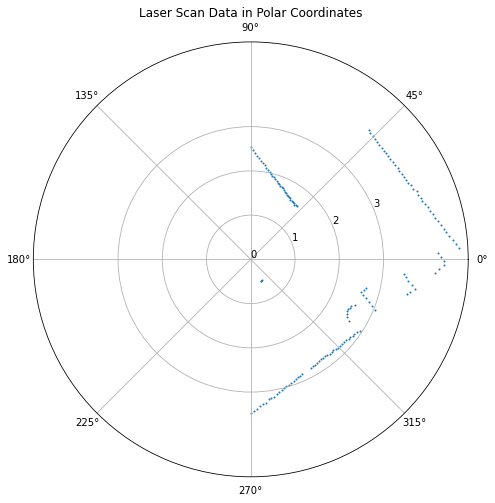

First 10 polar coordinates (angle, range):
Angle: -1.57 radians, Range: 3.48 meters
Angle: -1.55 radians, Range: 3.44 meters
Angle: -1.53 radians, Range: 3.39 meters
Angle: -1.51 radians, Range: 3.33 meters
Angle: -1.49 radians, Range: 3.27 meters
Angle: -1.46 radians, Range: 3.26 meters
Angle: -1.44 radians, Range: 3.19 meters
Angle: -1.42 radians, Range: 3.17 meters
Angle: -1.40 radians, Range: 3.15 meters
Angle: -1.38 radians, Range: 3.10 meters


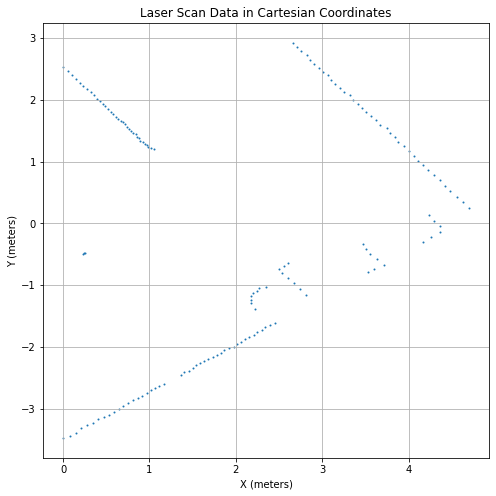

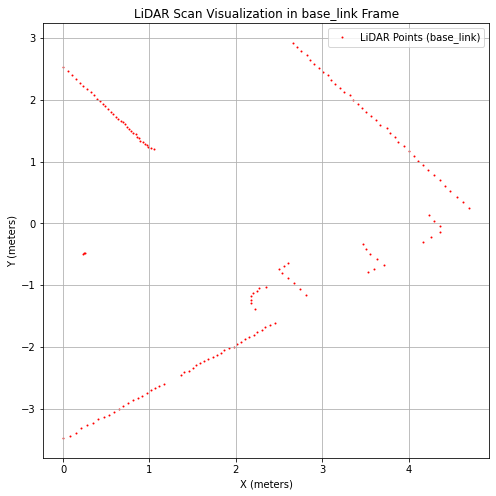

In [48]:
#Main Function defined here
def main():

    if not rclpy.ok():
        rclpy.init()

    user_defined_timestamp = 986.001 

    bag_file_path = '../../bag_22_10_24/'

    tf_static_coordinates = extract_tf_static_transformations(bag_file_path)
    print(f"Extracted {len(tf_static_coordinates)} transformation matrices from /tf_static.")

  
    closest_lidar_scan = read_bagfile_and_get_closest_scan(bag_file_path, user_defined_timestamp)

    
    if closest_lidar_scan:
        print(f"LaserScan ranges (first 10 values): {closest_lidar_scan.ranges[:10]}") 
        plot_polar(closest_lidar_scan) 

       
        x_points, y_points = convert_scan_to_cartesian(closest_lidar_scan)

        
        plot_cartesian(x_points, y_points)

        plot_lidar_scan(x_points, y_points)

    if rclpy.ok():
        rclpy.shutdown()

if __name__ == "__main__":
    main()

#### How does this visualisation compare to the previous visualisation of the same data? Is this what you expected? [5 points]

We expected a significant difference between the visualizations before and after transforming the LiDAR data to the base_link frame, but both plots appeared the same. This happened because the LiDAR sensor is likely fixed relative to the robot's body, and the transformation between the LiDAR frame and base_link is just a small translation or rotation that doesn’t drastically alter the point cloud's shape. Since the sensor is already closely aligned with the base_link frame, the transformation only introduces a minor shift in the data, which is not visually noticeable in a 2D plot. The relative positions of the points remain the same, and the transformation doesn’t significantly affect the appearance of the plot. This outcome is expected, as the transformation between a fixed sensor and the robot’s base usually results in only small changes in position or orientation. Therefore, both plots appear identical because the transformation between the frames is minimal.